In [40]:
import os
import time
import pandas as pd
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns
import mglearn

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# import helperfunctions
from helperfunctions import fun_load_file, fun_preprocessing, fun_split_X_y
from helperfunctions import fun_convert_time, fun_fit_gridsearch_time
from helperfunctions import fun_train_score, fun_test_score, fun_best_model
from helperfunctions import plot_feature_importances

# start time count and load data
start_script = time.time()
data = fun_load_file(path='..\\01_data\\01_TSP', name='combined_train_instances_dennis.xlsx')
train_data = fun_preprocessing(data)
X, y = fun_split_X_y(train_data)

# create a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# save number of features and train sizes
n_features = X_train.shape[1]
train_size = f'{int(np.round(100 * len(X_train)/len(X)))} %'

# **Ensebmles of Decision Trees**
### **Random Forest**

In [41]:
# randomized grid search cross validation
param_distributions = {'max_features': range(15, n_features+1),
                       'max_depth': range(10, 25),
                       'max_leaf_nodes': range(1200, 1700),
                       'min_samples_leaf': range(1, 25),
                       'min_impurity_decrease': uniform(0, 0.005)}

random_grid_search = RandomizedSearchCV(estimator=RandomForestRegressor(n_estimators=50, bootstrap=True, random_state=0, n_jobs=-1, verbose=False),
                                        param_distributions=param_distributions, cv=3, 
                                        n_iter=100, scoring='neg_mean_absolute_percentage_error',
                                        random_state=0, n_jobs=-1, verbose=False)
fit_time = fun_fit_gridsearch_time(random_grid_search, X_train, y_train)

# view results of grid search cross validation
MAPE, RMSE = fun_best_model(random_grid_search, X_train, y_train, view_results_df=False, return_scores=True)

# save results to dictionary
results_dict = {}
results_dict['Random Forest (RGS)'] = {'MAPE': MAPE, 'RMSE': RMSE, 'Fit grid searach time': fit_time, 'CV computation time': None, 'Train size': train_size}

  CV MAPE train data: 7.4213000000000005 %
  CV RMSE train data: 1.7551

  Best model / parameter combination:


RandomForestRegressor(max_depth=15, max_features=34, max_leaf_nodes=1439,
                      min_impurity_decrease=0.0005866024019240551,
                      min_samples_leaf=12, n_estimators=50, n_jobs=-1,
                      random_state=0, verbose=False)

**Create new model with best parameters**

In [42]:
# random_grid_search.best_params_
best_params_ = {'max_depth': 17,
               'max_features': 27,
               'max_leaf_nodes': 1488,
               'min_impurity_decrease': 0.0007957311847112142,
               'min_samples_leaf': 12}

In [45]:
# train new model with best parameter combination but more trees
forest = RandomForestRegressor(n_estimators=200, **random_grid_search.best_params_, #best_params_
                               bootstrap=True, random_state=0, n_jobs=-1, verbose=False)

# estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
MAPE, RMSE, computation_time = fun_train_score(forest, X_train, y_train, cv=5, return_results=True)

# save results to dictionary
results_dict['Random Forest (Best model, more trees)'] = {'MAPE': MAPE, 'RMSE': RMSE, 'CV computation time': computation_time, 'Train size': train_size}

  CV MAPE train data:  7.4199 %
  CV RMSE train data:  2.2099
  CV computation time: 7 min, 30 sec


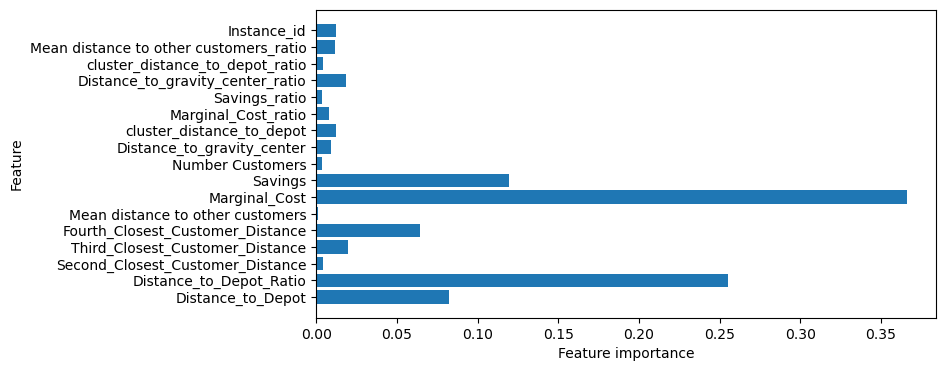

In [46]:
# view feature importances
forest.fit(X_train, y_train)
plot_feature_importances(forest, X_train, all_features=False)

**Gradient Boosting Regression Trees**

In [47]:
# randomized grid search cross validation
param_distributions = {'n_estimators': range(50, 100), 
                       'learning_rate': uniform(0, 0.5), #lower learning rate requires more trees
                       'max_depth': range(1, 25),
                       'max_leaf_nodes': range(1200, 1700)}#,
                       #'min_samples_leaf': range(1, 25),
                       #'max_features': range(15, n_features+1)}

random_grid_search = RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=0, verbose=False), param_distributions=param_distributions, cv=3,
                                        n_iter=100, scoring='neg_mean_absolute_percentage_error',
                                        random_state=0, n_jobs=-1, verbose=False)
fit_time = fun_fit_gridsearch_time(random_grid_search, X_train, y_train)

# view results of grid search cross validation
MAPE, RMSE = fun_best_model(random_grid_search, X_train, y_train, view_results_df=False, return_scores=True)

# save results to dictionary
results_dict['Gradient Boosting Regression Tree (RGS)'] = {'MAPE': MAPE, 'RMSE': RMSE, 'Fit grid searach time': fit_time, 'Train size': train_size}

**Create new model with best parameters**

In [ ]:
best_params_ = {'n_estimators': 1, #88
               'learning_rate': 0.09057548086845152, 
               'max_depth': 13, 
               'max_leaf_nodes': 1523}

In [ ]:
# train new model with best parameter combination but more trees
gbrt = GradientBoostingRegressor(**random_grid_search.best_params_,
                                 random_state=0, verbose=True)

# estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
MAPE, RMSE, computation_time = fun_train_score(gbrt, X_train, y_train, cv=5, return_results=True)

# save results to dictionary
results_dict['Gradient Boosting Regression Tree (Best model)'] = {'MAPE': MAPE, 'RMSE': RMSE, 'CV computation time': computation_time, 'Train size': train_size}

  CV MAPE train data:  90.05069999999999 %
  CV RMSE train data:  16.5772
  CV computation time: 0 sec


      Iter       Train Loss   Remaining Time 
         1         270.7068            0.00s


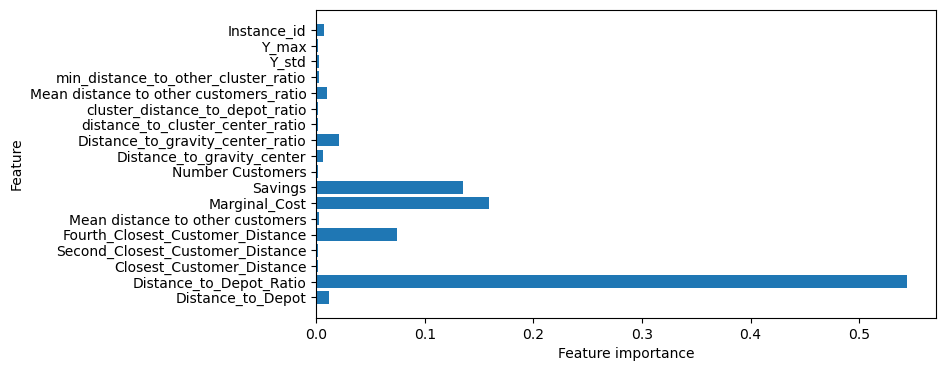

In [ ]:
# view feature importances
gbrt.fit(X_train, y_train)
plot_feature_importances(gbrt, X_train, all_features=False)

**Extreme Gradient Boosting: XGBoost-Package**

In [ ]:
# create model and fit it on train set (default parameters)
xgboost = xgb.XGBRegressor(objective='reg:squarederror',
                           n_estimators=None, 
                           learning_rate=None,
                           max_depth=None)

# estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
MAPE, RMSE, computation_time = fun_train_score(xgboost, X_train, y_train, cv=10, return_results=True)

# save results to dictionary
results_dict['XGBoost'] = {'MAPE': MAPE, 'RMSE': RMSE, 'CV computation time': computation_time, 'Train size': train_size}

  CV MAPE train data:  13.1303 %
  CV RMSE train data:  3.847
  CV computation time: 4 sec


# **Compare Results**

In [ ]:
display(pd.DataFrame(results_dict).sort_values(by='MAPE', axis=1))
print('Total script computation time:', fun_convert_time(start=start_script, end=time.time()))

,XGBoost,Random Forest (RGS),"Random Forest (Best model, more trees)",Gradient Boosting Regression Tree (RGS),Gradient Boosting Regression Tree (Best model)
MAPE,13.1303,21.5854,26.7297,73.1001,90.0507
RMSE,3.847,4.0598,7.575,13.127,16.5772
Fit gird searach time,NaN,3 sec,NaN,0 sec,NaN
CV computation time,4 sec,None,1 sec,NaN,0 sec
Train size,1 %,1 %,1 %,1 %,1 %


Total script computation time: 48 sec
